In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.explainer import Explainer
import pandas as pd
import torch

In [4]:
attributes =['title','manufacturer','price']

### Dataset creation

In [5]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/amazongoogle_rnn.pth')
rnn_model = rnn_model.cuda()

In [8]:
testneg = return_layer_input(rnn_model,rnn_model.classifier,
                             '../../datasets/Structured/Amazon-Google/','test_negatives')


Reading and processing data from "../../datasets/Structured/Amazon-Google/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [9]:
testpos = return_layer_input(rnn_model,rnn_model.classifier,'../../datasets/Structured/Amazon-Google/',
                                                                  'test_positives')


Reading and processing data from "../../datasets/Structured/Amazon-Google/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [10]:
negatives = return_layer_input(rnn_model,rnn_model.classifier,'../../datasets/Structured/Amazon-Google/','negatives')


Reading and processing data from "../../datasets/Structured/Amazon-Google/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [11]:
positives = return_layer_input(rnn_model,rnn_model.classifier,'../../datasets/Structured/Amazon-Google/','positives')


Reading and processing data from "../../datasets/Structured/Amazon-Google/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [12]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

### Negatives analysis

In [17]:
negatives_ri,neg_ri_norms = computeRi(rnn_model.classifier,
                                                    attributes,testneg,0)
torch.save(negatives_ri,'experiment_results/testneg_ri_RNN.pt')

100%|██████████| 2059/2059 [02:38<00:00, 13.00it/s]


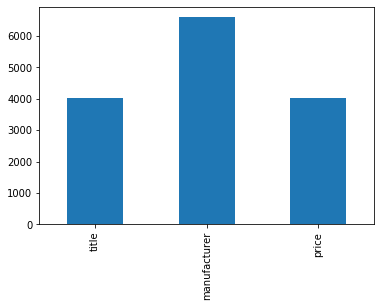

In [19]:
neg_ri_norms.sum().plot.bar()

## Test positives analysis

In [18]:
positives_ri,pos_ri_norms = computeRi(rnn_model.classifier,
                                                    attributes,testpos,1)
torch.save(positives_ri,'experiment_results/testpos_ri_RNN.pt')

100%|██████████| 234/234 [00:05<00:00, 41.06it/s]


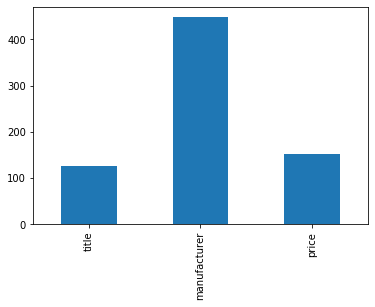

In [20]:
pos_ri_norms.sum().plot.bar()

## Compute nearest neighbours

### Considering all samples

In [21]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [ ]:
##run this cell to load pre-computed ri
negatives_ri = torch.load('experiment_results/testneg_ri_RNN.pt')
positives_ri = torch.load('experiment_results/testpos_ri_RNN.pt')

In [13]:
positives_nn = calculate_nearest_neighbors_onAttributes(testpos,positives_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 234/234 [00:00<00:00, 268.06it/s]


In [14]:
negatives_nn = calculate_nearest_neighbors_onAttributes(testneg,negatives_ri,
                                                              positives,attributes,attribute_len)

100%|██████████| 2059/2059 [00:02<00:00, 790.50it/s]


In [15]:
positives_nn.to_csv('experiment_results/testposNN_RNN.csv',index=False)
negatives_nn.to_csv('experiment_results/testnegNN_RNN.csv',index=False)

### Considering only training set